In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
df_tran = pd.read_csv('./dataset/tran.txt',names=['primary-date','time','approximate-indicator','secondary-date','approximate-indicator',
  'transaction-ID','player','type','from-team','from-league','to-team','to-league','draft-type','draft-round','pick-number','info'])
df_playerid = pd.read_csv('./dataset/playerid_list.csv',names=['LASTNAME','FIRSTNAME','PLAYERID','DAVENPORTCODE','MLBCODE','player'],skiprows=1);
df_master = pd.read_csv('./dataset/Master.csv')
df_batting = pd.read_csv('./dataset/Batting.csv')
df_pitching = pd.read_csv('./dataset/Pitching.csv')
df_fielding = pd.read_csv('./dataset/Fielding.csv')
df_batstat = pd.read_csv('./dataset/war_daily_bat.txt')
df_pitchstat = pd.read_csv('./dataset/war_daily_pitch.txt')
pd.set_option('display.max_columns', 60)

# Data Cleanup
# Recontructing invalid dates
df_tran['primary-date'] = df_tran['primary-date'].astype('str')
df_tran['primary-date'] = df_tran['primary-date'].str.replace(r'\A(\d{4})[0]{4}', r'\g<1>0101')
df_tran['primary-date'] = df_tran['primary-date'].str.replace(r'\A(\d{4})(..)[0]{2}', r'\g<1>\g<2>01')

#Extracting only trades from transaction dataframe
df_tran = df_tran[df_tran['type'] == "T "]
df_tran = df_tran[df_tran['to-league'].isin(['AL','NL'])]
df_tran = df_tran[df_tran['from-league'].isin(['AL','NL'])]

df_tran['primary-date'] = pd.to_datetime(df_tran['primary-date'], format='%Y%m%d')
df_tran['tranYear'] = df_tran['primary-date'].apply(lambda x : int(x.year))

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Baseline Model

In [2]:
df_master['player_ID'] = df_master['bbrefID']
df_batstat = pd.merge(df_batstat,df_master[['player_ID','retroID']],on='player_ID',how='inner')
df_pitchstat = pd.merge(df_batstat,df_master[['player_ID','retroID']],on='player_ID',how='inner')
df_batting = pd.merge(df_batting,df_master[['playerID','retroID','birthYear']],on='playerID')
df_pitching = pd.merge(df_pitching,df_master[['playerID','retroID','birthYear']],on='playerID')
df_fielding = pd.merge(df_fielding,df_master[['playerID','retroID','birthYear']],on='playerID')
df_batting['age']= df_batting['yearID'] - df_batting['birthYear']
df_pitching['age']= df_pitching['yearID'] - df_pitching['birthYear']
df_fielding['age']= df_fielding['yearID'] - df_fielding['birthYear']

df_batting['BA'] =  df_batting['H'] / ( df_batting['AB'] +  df_batting['SF'])
df_batting['SLP'] = (df_batting['H'] + df_batting['2B'] + 2 * df_batting['3B'] + 3 * df_batting['HR'])/df_batting['AB']

In [3]:
df_batstat.head()

,name_common,age,mlb_ID,player_ID,year_ID,team_ID,stint_ID,lg_ID,PA,G,Inn,runs_bat,runs_br,runs_dp,runs_field,runs_infield,runs_outfield,runs_catcher,runs_good_plays,runs_defense,runs_position,runs_position_p,runs_replacement,runs_above_rep,runs_above_avg,runs_above_avg_off,runs_above_avg_def,WAA,WAA_off,WAA_def,WAR,WAR_def,WAR_off,WAR_rep,salary,pitcher,teamRpG,oppRpG,oppRpPA_rep,oppRpG_rep,pyth_exponent,pyth_exponent_rep,waa_win_perc,waa_win_perc_off,waa_win_perc_def,waa_win_perc_rep,OPS_plus,TOB_lg,TB_lg,retroID
0,David Aardsma,22.0,430911.0,aardsda01,2004,SFG,1,NL,0,11,10.7,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.00,0.0,0.1,0.1,0.1,0.1,0.01,0.01,0.00,0.01,0.00,0.01,0.0,300000.0,Y,4.67546,4.67092,0.08651,4.67092,1.891,1.890,0.5005,0.5005,0.5005,0.5000,NaN,0.000,0.000,aardd001
1,David Aardsma,24.0,430911.0,aardsda01,2006,CHC,1,NL,3,45,53.0,-0.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.21,0.46,0.0,-0.2,-0.2,-0.2,0.2,-0.02,-0.02,0.00,-0.02,0.00,-0.02,0.0,NaN,Y,4.86164,4.86675,0.09085,4.86467,1.912,1.913,0.4995,0.4995,0.5005,0.4998,-100.0,0.694,0.896,aardd001
2,David Aardsma,25.0,430911.0,aardsda01,2007,CHW,1,AL,0,25,32.3,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.11,0.00,0.0,0.1,0.1,0.1,0.1,0.01,0.01,0.02,0.01,0.02,0.01,0.0,387500.0,Y,4.86335,4.85895,0.08422,4.85895,1.912,1.912,0.5004,0.5004,0.5004,0.5000,NaN,0.000,0.000,aardd001
3,David Aardsma,26.0,430911.0,aardsda01,2008,BOS,1,AL,1,47,48.7,-0.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.22,0.14,0.0,0.1,0.1,0.1,0.2,0.00,0.00,0.05,0.00,0.05,0.00,0.0,403250.0,Y,4.70549,4.70400,0.08092,4.70321,1.894,1.894,0.5001,0.5001,0.5005,0.4999,-100.0,0.345,0.434,aardd001
4,David Aardsma,27.0,430911.0,aardsda01,2009,SEA,1,AL,0,73,71.3,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.32,0.00,0.0,0.3,0.3,0.3,0.3,0.03,0.03,0.06,0.03,0.06,0.03,0.0,419000.0,Y,4.80227,4.79788,0.08302,4.79788,1.905,1.905,0.5004,0.5004,0.5004,0.5000,NaN,0.000,0.000,aardd001


In [4]:
df_batstat_sort = df_batstat.sort('age')
df_batstat_sort = df_batstat_sort[pd.notnull(df_batstat_sort['age'])]
agedict = {}

#print df_batstat_sort.age
for index, row in df_batstat_sort.iterrows():
    if(row['age'] in agedict):
        agedict[row['age']].append(row['WAR'])
    else:
        agedict[row['age']] = [row['WAR']]

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [5]:
age = []
avg_WAR= []
i=0
for key in agedict:
    if (~np.isnan(key)):
        avg = np.nansum(agedict[key]) / float(len(agedict[key]))
        age.append(key)
        avg_WAR.append(avg)
        
age_df = pd.DataFrame({ 'Age' : age,'Average_WAR' : avg_WAR}).sort('Age')

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [6]:
#age_df
def getAvgWarForAge(age):
    return (age_df[(age_df['Age'] == age)]['Average_WAR']).iloc[0]

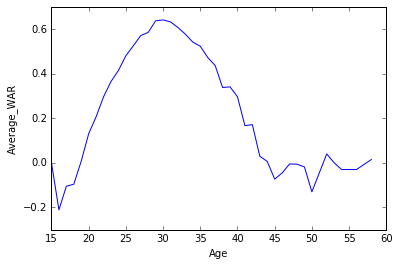

In [17]:
plt.xlabel("Age")
plt.ylabel("Average_WAR")
plt.plot(age_df.Age, age_df.Average_WAR);

In [20]:
def player_performance_projection(playerID, age):
    player_df = df_batstat[(df_batstat['retroID'] == playerID)]
    player_df_before = player_df[player_df['age']< age]
    diff = [0]
    for index,row in player_df_before.iterrows():
        diff.append(row['WAR'] - getAvgWarForAge(row['age']))
    mPerf  = np.mean(diff)    
    dict = {}
    for j in range(1,16):
        if age + j < 50:
            dict[j] = (getAvgWarForAge(age + j) + mPerf/j)
        else:
            dict[j] = 0
    return dict

In [8]:
def calculate_postion_score(retroID,age):
    pos = df_fielding[(df_fielding['retroID'] == retroID) & (df_fielding['age'] == age)]
    if pos.empty:
        return 0
    pos = pos.get_value(pos.index[0],'POS')
    score = 0
    if  pos == 'CF':
        score = 240
    if  pos == 'SS':
        score = 168
    if  pos == '2B':
        score = 132
    if  pos == '3B':
        score = 84
    if  pos == 'OF' or pos == 'LF' or pos == 'RF':
        score = 48
    if  pos == '1B':
        score = 12
    return score

def calculate_batting_similarity_score(retroID1,retroID2,age):
    p1 = df_batting[(df_batting['retroID'] == retroID1) & (df_batting['age'] == age)]
    p2 = df_batting[(df_batting['retroID'] == retroID2) & (df_batting['age'] == age)]
    if p1.empty or p2.empty:
        return 0
    p1 = p1.loc[p1.index[0]]
    p2 = p2.loc[p2.index[0]]
    posscore1 = calculate_postion_score(retroID1,age)
    posscore2 = calculate_postion_score(retroID2,age)
    score = 1000 - (p1['G']-p2['G'])/20 - (p1['AB'] - p2['AB'])/75 - (p1['R'] - p2['R'])/10 - (p1['H'] - p2['H'])/15 - (p1['2B'] - p2['2B'])/5 - (p1['3B'] - p2['3B'])/4 - (p1['HR'] - p2['HR'])/2 - (p1['RBI'] - p2['RBI'])/10 - (p1['IBB'] - p2['IBB'])/25 
    - (p1['SO'] - p2['SO'])/150 - (p1['SB'] - p2['SB'])/20 - (p1['BA'] - p2['BA'])/0.01 - (p1['SLP'] - p2['SLP'])/0.02 - (posscore1 - posscore2)
    return score

In [9]:
def calculate_pitching_similarity_score(retroID1,retroID2,age):
    p1 = df_pitching[(df_pitching['retroID'] == retroID1) & (df_pitching['age'] == age)]
    p2 = df_pitching[(df_pitching['retroID'] == retroID2) & (df_pitching['age'] == age)]
    if p1.empty or  p2.empty:
        return 0
    p1 = p1.loc[p1.index[0]]
    p2 = p2.loc[p2.index[0]]
    score = 1000 - abs(p1['W'] - p2['W']) - abs(p1['L'] - p2['L'])/2 - abs(p1['W'] - p2['W'])/abs((p1['G'] - p2['G'])*0.02) - abs(p1['ERA'] - p2['ERA'])/0.2
    - abs(p1['G'] - p2['G'])/10 - abs(p1['GS'] - p2['GS'])/20 - abs(p1['CG'] - p2['CG'])/20 - abs(p1['GF'] - p2['GF'])/50 - abs(p1['H'] - p2['H'])/50 
    - abs(p1['SO'] - p2['SO'])/20 - abs(p1['BB'] - p2['BB'])/10  - abs(p1['SHO'] - p2['SHO'])/5 - abs(p1['SV'] - p2['SV'])/3
    return score

In [10]:
def find_similar_players(retroID,age,year):
    player = df_batstat[(df_batstat['retroID'] == retroID)]
    ptchFlag = player.get_value(player.index[0],'pitcher')
    if ptchFlag == 'Y':
        playerList = df_batstat[(df_batstat['pitcher'] == 'Y') & (df_batstat['age'] == age) & (df_batstat['year_ID'] <= year)]
    else:
         playerList = df_batstat[(df_batstat['pitcher'] == 'N') & (df_batstat['age'] == age) & (df_batstat['year_ID'] <= year)]
    similarityList = []
    for index, row in playerList.iterrows():
        retroID2 = row['retroID']
        if retroID2 == retroID:
            continue
        if ptchFlag == 'N':
            result = calculate_batting_similarity_score(retroID,retroID2,age)
        else:
            result = calculate_pitching_similarity_score(retroID,retroID2,age)
        similarityList.append((retroID2,result))
    return similarityList

In [13]:
def trade_value_year_projection(tranID,metric):
    td = df_tran[(df_tran['transaction-ID'] == tranID)]
    teams = td['from-team'].unique()
    val = 0
    player_vals = []
    for x in teams:
        valDict = {}
        for index, row in td.iterrows():
            val = 0
            if (row['from-team'] == x):
                if pd.isnull(row['player']):
                    # filter out cash transactions or yet to be named player transaction
                    continue
                print( row['player'])
                birthYear = df_master['birthYear'][df_master['retroID'] == row['player']]
                if birthYear.empty:
                    continue
                birthYear = birthYear.iloc[0]
                age = row['tranYear'] - birthYear
                splayers= []
                if row['tranYear'] > 1920:
                    splayers = find_similar_players(row['player'],age,row['tranYear'])
                    if not splayers:
                        stuple = sorted(splayers,key=lambda x: x[1], reverse=True)[0]
                        retID = stuple[0]
                        player_df = df_batstat[(df_batstat['retroID'] == retID)]
                        #instead need a df for the player after the trans year, and not just next, but all consecutive years
                        for i in range(1,16):
                            player_df_year_next = player_df[(player_df['age'] == (age + i))]
                            if not player_df_year_next.empty:
                                # get the value of metric for each year after trade until 15 years else assume 0
                                t = float(player_df_year_next[metric].iloc[0])
                                #print(t)
                                if i in valDict.keys():
                                    valDict[i] += t
                                else:
                                    valDict[i] = t
                            else:
                                ## figure out a way to find war for these players
                                if i in valDict.keys():
                                    valDict[i] += 0
                                else:
                                    valDict[i] = 0
                else:
                    tempDict = player_performance_projection(row['player'],age)
                    for i in range(1,16):
                        if i in valDict.keys():
                            valDict[i] += tempDict[i]
                        else:
                            valDict[i] = tempDict[i]
        player_vals.append(valDict)
    return player_vals

In [12]:
import scipy.optimize as optimize
def f(c):
    ret = 0.0
    for key, value in dict1.items():
        ret  += pow((1 - c[0]/100),key)*value
    for key, value in dict2.items():
        ret  -= pow((1 - c[1]/100),key)*value
    return abs(ret)

bnds = ((0, 100), (0, 100))

In [28]:
trade_val_projection_list = []
new_df_tran = df_tran[df_tran['tranYear'] >1990]
transactions = new_df_tran['transaction-ID'].unique()
for x in transactions:
    listnew = trade_value_year_projection(x,'WAR')
    dict1 = listnew[0]
    dict2 = listnew[1]
    result = optimize.minimize(f, (50, 50), method='TNC', bounds=bnds)
    trade_val_projection_list.append((x,result.x,result.fun))

azoco001
humpm001
caldi001
joneb002
raint001
cartj002
Mario Brito
harnp001
schic002
finls001
davig001
robij002
tettm001
Rob Blumberg
gonzr001
campk001
vered001
neelt001
arndl001
Dave Richards
hanet001
parkd001
bichd001
leitm001
lovut001
shiet001
Tony Beasley
varsg001
carts001
allaa001
Jim Baxter
coraj001
Kevin Garner
newsw001
petea001
roses001
rosep002
boroj001
kremj001
Keith Morrison
nixoo001
Boi Rodriguez
gardm002
murpr001
Terrel Hansen
Dave Sommer
reedd001
diaza001
hallj001
Willie Magallanes
Greg Sims
meyej001
mcelc001
scanb001
willm002
wilkd001
baldj001
colev002
martc001
Kevin Castleberry
heepd001
yorkm001
websm001
Jim Blueberg
blowm001


KeyboardInterrupt: 

In [22]:
def trade_value_year_actual(tranID,metric):
    td = df_tran[(df_tran['transaction-ID'] == tranID)]
    teams = td['from-team'].unique()
    val = 0
    player_vals = []
    for x in teams:
        valDict = {}
        for index, row in td.iterrows():
            val = 0
            if (row['from-team'] == x):
                if pd.isnull(row['player']):
                    # filter out cash transactions or yet to be named player transaction
                    continue
                player_df = df_batstat[(df_batstat['retroID'] == row['player'])]
                player_df_year = player_df[(player_df['year_ID'] == row['tranYear'])]
                #instead need a df for the player after the trans year, and not just next, but all consecutive years
                for i in range(1,15):
                    player_df_year_next = player_df[(player_df['year_ID'] == (row['tranYear'] + i))]
                    if not player_df_year_next.empty:
                        # get the value of metric for each year after trade until 15 years else assume 0
                        t = float(player_df_year_next[metric].iloc[0])
                        #print(t)
                        if i in valDict.keys():
                            valDict[i] += t
                        else:
                            valDict[i] = t
                    else:
                        ## figure out a way to find war for these players
                        if i in valDict.keys():
                            valDict[i] += 0
                        else:
                            valDict[i] = 0
        player_vals.append(valDict)
    return player_vals

In [29]:
def f2(c,dict_1,dict_2):
    ret = 0.0
    for key, value in dict_1.items():
        ret  += pow((1 - c[0]/100),key)*value
    for key, value in dict_2.items():
        ret  -= pow((1 - c[1]/100),key)*value
    return abs(ret)

diff_list = [] 
for i in trade_val_projection_list:
    listnew = trade_value_year_actual(i[0],'WAR') #should come from projections instead of actual value
    act = f2( i[1], listnew[0], listnew[1])
    diff_list.append((i[0],act))
sorted(diff_list,key=lambda x: x[1], reverse=True)

[(51828, 3.8336468505859371),
 (51829, 3.5850000000000004),
 (51841, 2.5025781250000003),
 (51826, 2.1848608398437497),
 (51830, 1.4403124999999999),
 (51839, 1.0387500000000003),
 (51834, 1.0274414062500004),
 (51832, 0.73750000000000004),
 (75844, 0.4830859374999999),
 (51850, 0.41562499999999997),
 (51837, 0.25999999999999995),
 (51813, 0.25250000000000006),
 (51846, 0.20248046875000006),
 (51835, 0.15037109375000002),
 (51838, 0.11750000000000001),
 (51833, 0.094687499999999994),
 (51848, 0.035000000000000003),
 (51842, 0.027499999999999997),
 (51844, 0.026093750000000002),
 (51836, 0.01),
 (51831, 0.007880859375000002),
 (51840, 0.0037982177734374998),
 (51845, 0.0),
 (51847, 0.0),
 (51849, 0.0)]